In [31]:
# initiation: 2020-02-10T15:00:00+01:00
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
import seaborn as sns
import constrNMPy
import latex 
import os

plt.rcParams['font.sans-serif'] = ['Arial'] # set the font inline to Arial

# os.getcwd() 
os.chdir('/Users/abel/Desktop/Junior/CogMod/Assignments/H2') # change the working directory to the folder where the data is stored

# color pallette
[g,y,r,b,p,i,k] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']

## 模拟单次训练过程
首先，我们需要编写一个函数来计算每次训练中鸽子的啄食次数。由于每次训练开始时light和bell各自独立地随机产生cue，所以存在[1,1],[1,0],[0,1],[0,0]四种情况。
在每次训练中，我们根据当前状态的链接强度计算该状态下鸽子啄食的期望次数，并按照泊松分布生成实际的啄食次数。
下面的training函数展示了训练的过程，在符合条件下有0.7的概率获得食物。

而前100次会对light和bell进行奖赏，而100次之后只会对light的出现进行强化。

In [40]:
import numpy as np
from scipy.stats import poisson

def training(w1, w2, tn):
    ''' 
    Simulating the response process in each trial
    Input: 
    w1 & w2 are the association strengths of the two cues
    tn: the trial number
    Output: reward & the number of pecking
    '''
    
    light = np.random.choice([0, 1]) # light is on with 50% probability
    bell = np.random.choice([0, 1]) # bell is on with 50% probability
    rp = np.random.uniform(0, 1) # random number between 0 and 1
    givep = 0.9; nop = 0.1; # probability of giving reward and not giving reward

    
    # all the possible states and rewards
    if tn <= 100:        
        # when under 100 trials, reward is given when either light or bell is on        
        if light == 1 or bell == 1:
            if rp <= givep:
                reward = 1
            else:
                reward = 0
        else: 
            if rp <= nop:
                reward = 1
            else:
                reward = 0            
    else: # when over 100 trials, reward is given only when light is on
        if light == 1 and bell == 0:
            if rp <= givep:
                reward = 1
            else:
                reward = 0
        else: 
            if rp <= nop:
                reward = 1
            else:
                reward = 0

    # generating responses
    lam = max(100 * (light*w1 + bell*w2), 5)
    N = poisson.rvs(lam)
    
    return light, bell, reward, N


## 模拟整个实验过程

之后我们模拟整个实验过程，给定训练次数和learning rate，每次鸽子通过自己预期和实际的差值更新weight，并且在之后的试次中应用，生成新的lamda。

In [41]:
def simulate_experiment(num_trainings, alpha):
    w1, w2 = 0, 0
    w1_trace = [w1]
    w2_trace = [w2]
    light_trace = []
    bell_trace = []
    reward_trace = []
    response = []
    lst =[]
    
    for i in range(1,num_trainings):
        w1, w2 = w1_trace[i-1], w2_trace[i-1]
        
        [light, bell, reward, N] = training(w1, w2, i)
        
        light_trace.append(light)
        bell_trace.append(bell)
        reward_trace.append(reward)
        response.append(N)

        # update the association strength
        prediction = light*w1 + bell*w2
        error = reward - prediction
        w1 = w1 + alpha * error * light
        w2 = w2 + alpha * error * bell

        lst.append(prediction)
        w1_trace.append(w1)
        w2_trace.append(w2)
        
    return w1_trace, w2_trace, light_trace, bell_trace, reward_trace, response, lst 


## 可视化训练
假定训练200次

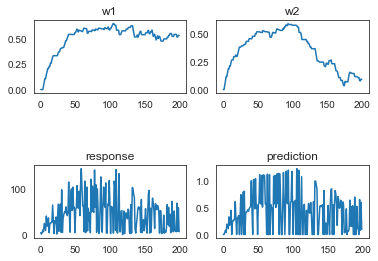

In [55]:
[w1_trace, w2_trace, light_trace, bell_trace, reward_trace, response, lst] = simulate_experiment(200,0.04);
plt.subplot(2,2,1);
plt.plot(w1_trace);
plt.title('w1');
plt.subplot(2,2,2);
plt.plot(w2_trace);
plt.title('w2')
plt.subplot(2,2,3);
plt.plot(response);
plt.title('response')
plt.subplot(2,2,4);
plt.plot(lst);
plt.title('prediction')

plt.subplots_adjust(hspace=1)

对response的可视化精细一些

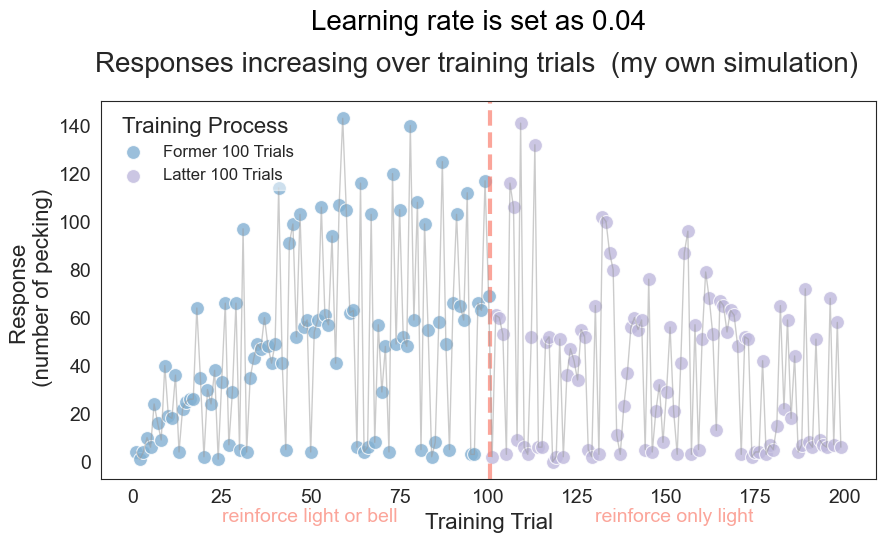

In [56]:
# plot the data
sns.set_style("white")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=100)
trial = np.arange(1,200)
dt = pd.DataFrame({'trial': trial, 'response': response})
# Plot the first scatter plot on the left subplot
df_first = dt[dt['trial'] < 101];df_second = dt[dt['trial'] >= 101]
sns.scatterplot(x='trial', y='response', data=df_first, s=100, color=b, alpha=0.8, ax=axes, label='Former 100 Trials')
sns.scatterplot(x='trial', y='response', data=df_second, color=p, alpha=0.8, ax=axes, s=100, label='Latter 100 Trials',)
plt.legend( loc='upper left', fontsize=12, title='Training Process', title_fontsize=16,
             facecolor='white' , framealpha=0.5, edgecolor='white')
axes.axvline(x=100.5, color= r, linestyle='--', linewidth=3, alpha = 0.7, label='Training Phase')  # vertical line
axes.text(25, -25, 'reinforce light or bell', fontsize=14, color=r, alpha=0.7)
axes.text(130,-25, 'reinforce only light', fontsize=14, color=r, alpha=0.7)
axes.text(50, 180, 'Learning rate is set as 0.04', fontsize=20, color='black', alpha=1)
plt.plot(dt['trial'], dt['response'], color = k, alpha = 0.5, linewidth = 1)
# Set titles and axis labels
fig.suptitle('''Responses increasing over training trials  (my own simulation)''', fontsize=20)
plt.xlabel('Training Trial', fontsize=16)
plt.ylabel('Response \n (number of pecking)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [14]:
w1_trace.pop()# remove the last element
w2_trace.pop()
dt = pd.DataFrame({'light':light_trace, 'bell':bell_trace,'w1':w1_trace, 'w2':w2_trace, 'response':response, 'reward':reward_trace, 'prediction':lst})
dt

,light,bell,w1,w2,response,reward,prediction
0,0,1,0.000000,0.000000,7,1,0.000000
1,0,0,0.000000,0.030000,9,0,0.000000
2,1,1,0.000000,0.030000,2,1,0.030000
3,1,0,0.029100,0.059100,5,1,0.029100
4,0,0,0.058227,0.059100,7,0,0.000000
...,...,...,...,...,...,...,...
194,1,0,0.359793,0.003155,30,0,0.359793
195,1,1,0.348999,0.003155,35,0,0.352155
196,0,1,0.338435,-0.007409,9,0,-0.007409
197,1,1,0.338435,-0.007187,30,0,0.331248


再写一个拟合这个过程的函数来对数据集进行拟合：

In [15]:
from scipy.stats import poisson

def rescorla_wagner(alpha, outcomes, response, cues):
    """
    Fit the Rescorla-Wagner model to a set of outcomes and cues.

    :param alpha: learning rate
    :param outcomes: a list of actual outcomes
    ：param response: a list of actual responses；
            response is generated by poisson distribution of lambda = max(100*(w_1*cues[0] + w_2*cues[1]),5)
    :param cues: a list of cues that predicted the outcomes； 
            cues[0] is the cue for the first outcome, cues[1] is the cue for the second outcome
    :return: negative log likelihood of the Rescorla-Wagner model
    """
    # Initialize the prediction error and the negative log likelihood
    error = np.zeros(len(outcomes))
    w_1 = [0] ; w_2 = [0] ; prediction = []; lams = [];
    nll = 0
    
    # Loop through each trial
    for t in range(len(outcomes)):
        
        # Calculate the prediction error
        prediction.append(cues[0][t] * w_1[t] + cues[1][t] * w_2[t])
        error[t] = outcomes[t] - prediction[t]
         
        # Calculate the negative log likelihood
        # lams.append(max((100*(w_1[t] + w_2[t])),5))
        lams.append(max((100*(w_1[t]*cues[0][t] + w_2[t]*cues[1][t])),5))
        prob = poisson.pmf(response[t],lams[t])
        nll += -np.log(prob)
        
        # Update the prediction of the outcome
        w_1.append(w_1[t] + alpha * error[t] * cues[0][t])
        w_2.append(w_2[t] + alpha * error[t] * cues[1][t])

    return nll, w_1, w_2, prediction,lams

def nll_rescorla_wagner(params, *args): # negative log likelihood
    return rescorla_wagner(params, *args)[0]
